<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [125]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Import/Helpers

In [25]:
import findspark
findspark.init()
from pyspark import SQLContext, SparkContext
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics as S
import json
import numpy as np

from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
def correlation(df, col1, col2, method='pearson'):
    rdd1 = df.select(col1).rdd.map(lambda x: x[0])
    rdd2 = df.select(col2).rdd.map(lambda x: x[0])
    return S.corr(rdd1, rdd2, method)

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

# Reviews

We load the data from the json file. The data is a small subset containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food".

In [44]:
df = sqlContext.read.json("reviews_auto_baby_grocery.json")
num_reviews = df.count()

## >= 5 Reviews

We get the count of review of distinct article per reviewer and filter those that have less than 5 review.

In [45]:
df_count = df.groupBy("reviewerID").agg(F.countDistinct("asin").alias('count')).filter("`count` >= 5")

We get all reviews of reviewers with more than 5 articles.

In [48]:
df_filtered = df.join(df_count, on='reviewerID').drop('count')
num_five_reviews = df_filtered.count()

In [53]:
print("We have %.3f%% of review who belongs to reviewer with 5 or more reviews"%(num_five_reviews/num_reviews))

We have 0.278% of review who belongs to reviewer with 5 or more reviews


We compute the average grade for each reviewer.

In [6]:
average_score = df_filtered.groupBy("reviewerID").avg("overall").select("avg(overall)")

In [7]:
average_std_score = df_filtered.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
average_std_score.cache().count()

109193

In [8]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|            109193|            109193|
|   mean|4.2834718157516365|0.9022456674075624|
| stddev|0.6049040387948184|0.5699621176391938|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



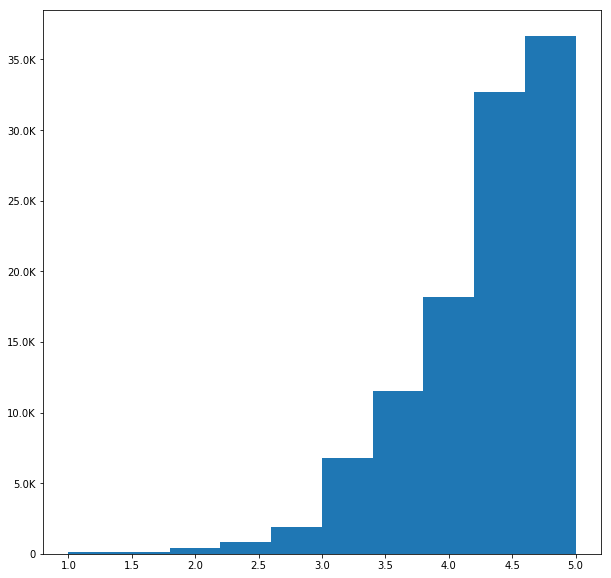

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("mean"));

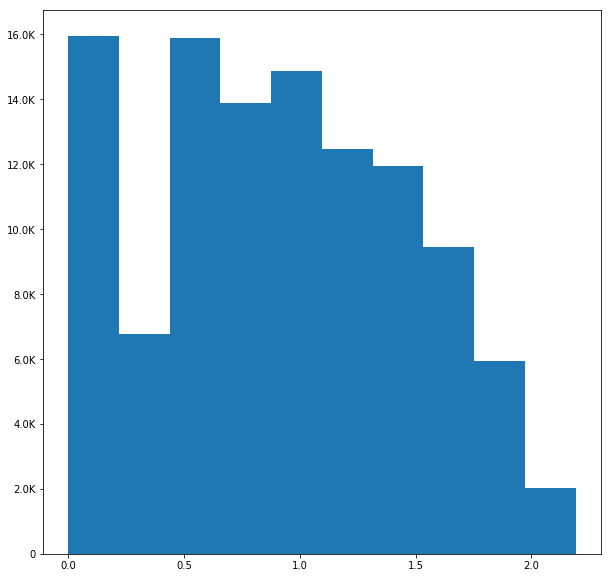

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("std"));

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 14.72% of reviewer with std < 0.25


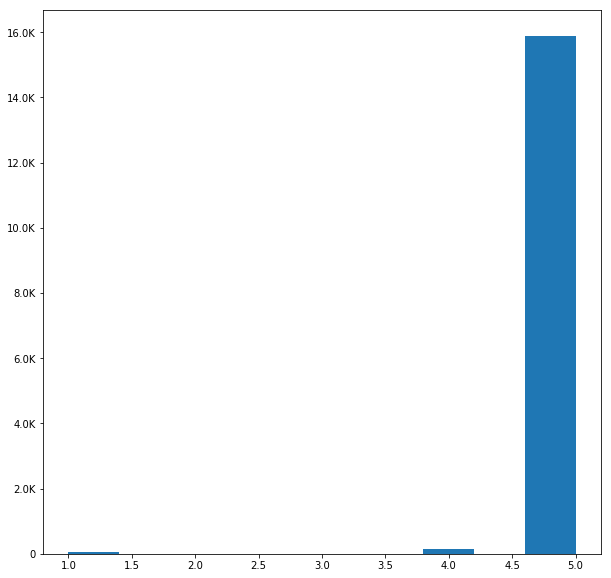

In [11]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.25).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.filter(average_std_score.std < 0.25).select("mean"));

## Word count
Here we count the number of word in a certain review.

In [108]:
wordCount = F.udf(lambda text: len(text.split(" ")), T.IntegerType())

df = df.withColumn('wordcount', wordCount(df["reviewText"]))
df.select("wordcount").describe().show()
overall = df.select("overall").rdd.map(lambda x: x[0])
wordcount = df.select("wordcount").rdd.map(lambda x: x[0])
pearson_corr = correlation(df, "overall", "wordcount", method='pearson')
spearman_corr = correlation(df, "overall", "wordcount", method='spearman')
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

+-------+-----------------+
|summary|        wordcount|
+-------+-----------------+
|  count|          3586370|
|   mean| 66.7637979349593|
| stddev|72.96104458476789|
|    min|                1|
|    max|             5019|
+-------+-----------------+

The pearson correlation is -0.090 and the spearman is -0.148


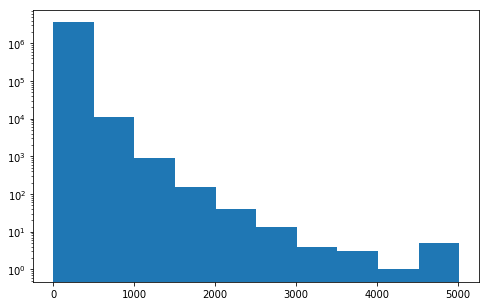

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
hist(ax, df.select("wordcount"), log=True);

In [110]:
pearson_corr = correlation(df.filter(df.wordcount > 1000), "overall", "wordcount", method='pearson')
spearman_corr = correlation(df.filter(df.wordcount > 1000), "overall", "wordcount", method='spearman')

In [117]:
df.filter(df.wordcount > 2000).select("overall").describe().show()

+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|                68|
|   mean| 4.132352941176471|
| stddev|1.2447431163947509|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [111]:
print("The pearson correlation is %.3f and the spearman is %.3f"%(pearson_corr, spearman_corr))

The pearson correlation is 0.046 and the spearman is 0.037


## Helpfulness
We get the "helpfulness" of a review by computing the ratio of people that found a review helpful and those that voted. If we have no data, we simply put -1 as a ratio.

In [73]:
df = df.withColumn("helpfulness", F.when(df.helpful.getField(1) > 0, df.helpful.getField(0)/df.helpful.getField(1)).otherwise(-1))

In [74]:
df.filter(df["helpfulness"] >= 0.0).select("helpfulness").describe().show()

+-------+------------------+
|summary|       helpfulness|
+-------+------------------+
|  count|           1364262|
|   mean|0.7483669013110577|
| stddev|0.3643935280677649|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



There seems to have some discrepancies amongst the ratio, since the max is at 2.0. We will check that it does not occur too often and may drop the data in the future.

In [75]:
df.filter(df["helpfulness"] > 1.0).select("helpful").show()

+-------+
|helpful|
+-------+
| [2, 1]|
| [3, 2]|
+-------+



In [76]:
df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).corr("overall", "helpfulness")

0.25069243577398675

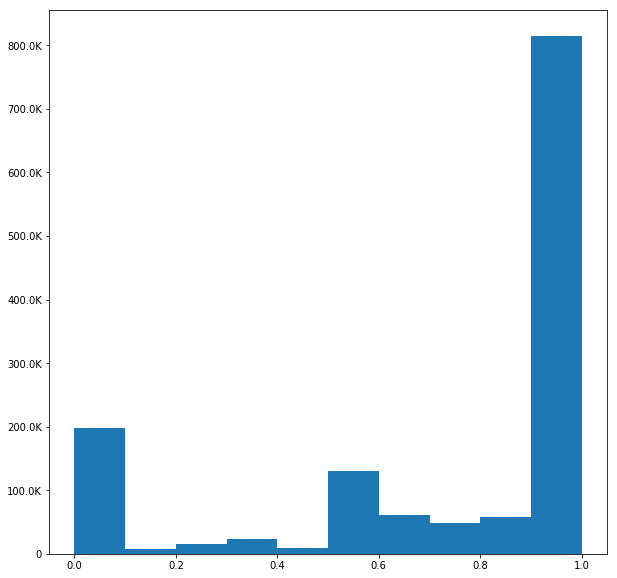

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("helpfulness"));

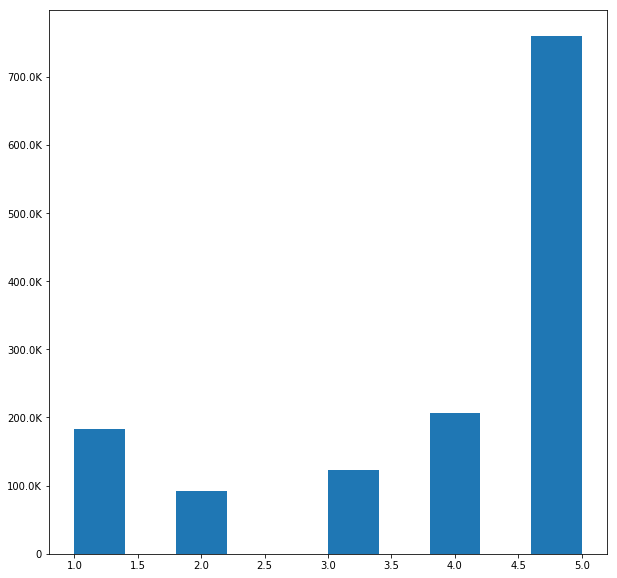

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("overall"));

In [102]:
overall = df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("overall").rdd.map(lambda x: x[0])
helpfulness = df.filter((df["helpfulness"] >= 0.0) & (df["helpfulness"] <= 1.0)).select("helpfulness").rdd.map(lambda x: x[0])
S.corr(overall, helpfulness, method='spearman')

0.26402032124281005

## Brand fidelity/hate

In [128]:
df_meta = sqlContext.read.json("meta_auto_baby_grocery.json")

In [133]:
df_meta

DataFrame[_corrupt_record: string, asin: string, brand: string, categories: array<array<string>>, description: string, imUrl: string, price: double, related: struct<also_bought:array<string>,also_viewed:array<string>,bought_together:array<string>,buy_after_viewing:array<string>>, salesRank: struct<Arts, Crafts & Sewing:bigint,Automotive:bigint,Baby:bigint,Beauty:bigint,Camera &amp; Photo:bigint,Cell Phones & Accessories:bigint,Clothing:bigint,Computers & Accessories:bigint,Electronics:bigint,Grocery & Gourmet Food:bigint,Health & Personal Care:bigint,Home &amp; Kitchen:bigint,Home Improvement:bigint,Industrial & Scientific:bigint,Jewelry:bigint,Kitchen & Dining:bigint,Movies & TV:bigint,Music:bigint,Musical Instruments:bigint,Office Products:bigint,Patio, Lawn & Garden:bigint,Pet Supplies:bigint,Shoes:bigint,Software:bigint,Sports &amp; Outdoors:bigint,Toys & Games:bigint,Video Games:bigint,Watches:bigint>, title: string]